# **Notebook to generate images from prompt with clip skip config**

## **Check Environment**

In [1]:
import os

if 'COLAB_GPU' in os.environ:
    print("Environment is colab")
    env = "colab"
elif 'KAGGLE_URL_BASE' in os.environ:
    env = "kaggle"
    print("Environment is kaggle")
else:
    env = "local"
    print("Environment is local")

Environment is colab


In [2]:
#Clone Repo and Change Working Directory
if env != "local":
    !git clone https://github.com/kk-digital/kcg-ml-sd1p4.git
    %cd kcg-ml-sd1p4/
else:
    !cd ..
    # update repo
    !git pull

fatal: destination path 'test_kcg' already exists and is not an empty directory.
/content/test_kcg


# **Computing Platform Check GPU (CUDA) or CPU / Environment**

In [3]:
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    print ('[WARNING] CUDA/GPU is not available! Compute-intensive scripts on this notebook will be run on CPU.')
    device =  "cpu"

### **Set ENV_TYPE**
If ENV_TYPE is equal to "test", then some examples of data will be run in order to test whether the notebooks running or not.
Otherwise, the notebook will run on the whole *dataset*

In [4]:
ENV_TYPE="test"

In [5]:
# download model weights
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

--2023-06-19 01:21:55--  https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt
Resolving huggingface.co (huggingface.co)... 18.155.68.38, 18.155.68.121, 18.155.68.44, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/4c/37/4c372b4ebb57bbd02e68413d4951aa326d4b3cfb6e62db989e529c6d4b26fb21/fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sd-v1-4.ckpt%3B+filename%3D%22sd-v1-4.ckpt%22%3B&Expires=1687393876&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzRjLzM3LzRjMzcyYjRlYmI1N2JiZDAyZTY4NDEzZDQ5NTFhYTMyNmQ0YjNjZmI2ZTYyZGI5ODllNTI5YzZkNGIyNmZiMjEvZmU0ZWZmZjFlMTc0YzYyNzI1NmU0NGVjMjk5MWJhMjc5YjM4MTZlMzY0YjQ5ZjliZTJhYmMwYjNmZjNmODU1Nj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaG

# **Install the requirements**

In [6]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import the Module/Utility**

In [7]:
import time
import sys
import os
import torch
from labml import monit
from datetime import datetime
import numpy as np
import cv2
import hashlib
from PIL import Image
import matplotlib.pyplot as plt

sys.path.insert(0, "./scripts")
from stable_diffusion_base_script import StableDiffusionBaseScript
from stable_diffusion.utils.model import save_images, set_seed, get_autocast
from stable_diffusion.model.unet_attention import CrossAttention

In [8]:
class Txt2Img(StableDiffusionBaseScript):
    """
    ### Text to image class
    """

    @torch.no_grad()
    def generate_images(self, *,
                 seed: int = 0,
                 batch_size: int = 1,
                 prompt: str,
                 h: int = 512, w: int = 512,
                 uncond_scale: float = 7.5,
                 low_vram: bool = False,
                 num_clip_skip: int = 0,
                 ):
        """
        :param seed: the seed to use when generating the images
        :param dest_path: is the path to store the generated images
        :param batch_size: is the number of images to generate in a batch
        :param prompt: is the prompt to generate images with
        :param h: is the height of the image
        :param w: is the width of the image
        :param uncond_scale: is the unconditional guidance scale $s$. This is used for
            $\epsilon_\theta(x_t, c) = s\epsilon_\text{cond}(x_t, c) + (s - 1)\epsilon_\text{cond}(x_t, c_u)$
        :param low_vram: whether to limit VRAM usage
        """
        # Number of channels in the image
        c = 4
        # Image to latent space resolution reduction
        f = 8

        if seed == 0:
            seed = time.time_ns() % 2**32

        set_seed(seed)
        # Adjust batch size based on VRAM availability
        if low_vram:
            batch_size = 1

        # Make a batch of prompts
        prompts = batch_size * [prompt]

        # AMP auto casting
        autocast = get_autocast()
        with autocast:
            self.clip_skip(num_clip_skip)
            un_cond, cond = self.get_text_conditioning(uncond_scale, prompts, batch_size)

            # [Sample in the latent space](../sampler/index.html).
            # `x` will be of shape `[batch_size, c, h / f, w / f]`
            x = self.sampler.sample(cond=cond,
                                    shape=[batch_size, c, h // f, w // f],
                                    uncond_scale=uncond_scale,
                                    uncond_cond=un_cond)

            return self.decode_image(x)


## **Generate images from prompt and size**

In [9]:
# create an instance of the class
sampler_name = 'ddim'
steps = 50
batch_size = 4
scale = 7.5
txt2img = Txt2Img(checkpoint_path='./sd-v1-4.ckpt',
                      sampler_name=sampler_name,
                      n_steps=steps)
txt2img.initialize_script()

INFO: Using CUDA device: Tesla T4


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.21.mlp.fc1.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.la

In [10]:
prompt = "a photograph of an astronaut riding a horse"
dest_path='./output_images'

In [11]:
def generate_image(prompt, dest_path, num_clip_skip):
    images= txt2img.generate_images(batch_size=1, prompt=prompt, num_clip_skip=num_clip_skip)
    os.makedirs(dest_path, exist_ok=True)
    filename = f"clip_skip_image.jpg"
    file_path = os.path.join(dest_path,filename)
    save_images(images, file_path)

In [12]:
generate_image(prompt, dest_path, 1)

running clip skip with number of hidden layers :1
['a photograph of an astronaut riding a horse']


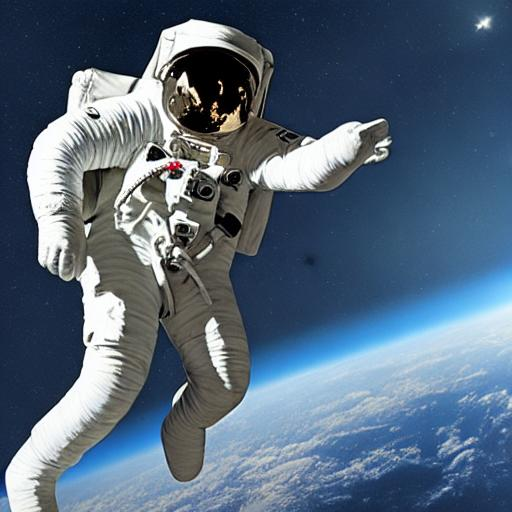

In [13]:
# show the first image
from PIL import Image
Image.open('./output_images/clip_skip_image.jpg')